# Imports

In [1]:
!pip install clean-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 4.0 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.9 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171031 sha256=23f0da2e614247e737142b4fd9ee57f1b413f18b662c31f47100ba43461519ae
  Stored in directory: /root/.cache/pip/wheels/bd/22/e5/b69726d5e1a19795ecd3b3e7464b16c0f1d019aa94ff1c8578
Successfully built emoji
  Attempting uninstall: emoji
    Found existing installation: emoji 2.15.0
    Uninstalling emoji-2.15.0:
      Successfully uninstalled emoji-2.15.0


In [3]:
# misc
import os
import json
import math
import re
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset, DatasetDict
from cleantext import clean

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


In [4]:
torch.manual_seed(42)
np.random.seed(42)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

Running on device: cuda


# Dataset

In [6]:
ground_truth_df = pd.read_csv('/kaggle/input/erisk25/final-eriskt2-dataset-with-ground-truth/final-eriskt2-dataset-with-ground-truth/shuffled_ground_truth_labels.txt', sep=' ', header=None)
ground_truth_df.columns = ['user', 'is_depressed']
ground_truth_df.head()

,user,is_depressed
0,subject_BAPb4sn,0
1,subject_x12ArlU,0
2,subject_D1lB5nr,0
3,subject_aEK9WJt,0
4,subject_OpiNZAB,0


In [7]:
posts = {}
root_dir = '/kaggle/input/erisk25/final-eriskt2-dataset-with-ground-truth/final-eriskt2-dataset-with-ground-truth/all_combined'
for file in os.listdir(root_dir):
    file_path = os.path.join(root_dir, file)

    # user id
    user_id = file.split('.')[0]

    # reading the json file
    with open(file_path, 'r') as f:
        file_data = json.load(f)

    user_posts = []
    # using the file data
    for post in file_data:
        if post['submission']['target'] == True:
            user_posts.append(post['submission']['body'])

        comments = post['comments']
        for comment in comments:
            if comment['target'] == True:
                user_posts.append(comment['body'])

    posts[user_id] = user_posts

## Preprocessing

In [8]:
def preprocess(user_posts, N=35):
    """
    Your custom preprocessing method:
    Concatenates posts, cleans them, and splits into N character-based segments.
    """
    # Filter removed posts
    user_posts = list(filter(lambda x : x != '[removed]', user_posts))
    texts = ' '.join(user_posts)

    # Cleaning (Lower=False to keep case information if your model uses it)
    cleaned = clean(texts, lower=False, no_urls=True, no_punct=False, replace_with_url='')
    
    # Removing hashtags and excess whitespace
    cleaned = re.sub(r'#\w+', '', cleaned)
    cleaned = ' '.join(cleaned.split())

    if len(cleaned) == 0:
        return []

    # Convert into N segments (Character-based chunking)
    segment_size = math.ceil(len(cleaned) / N)
    segments = [cleaned[i : i+segment_size] for i in range(0, len(cleaned), segment_size)]

    # Padding logic (retained from your method)
    if len(segments) < N:
        segments += [""] * (N - len(segments))
    elif len(segments) > N:
        segments = segments[:N]

    return segments

In [9]:
processed_posts = {}
for user_id, user_post in posts.items():
    processed_posts[user_id] = preprocess(user_post)

len(processed_posts)

909

In [10]:
train_ids, test_ids = train_test_split(ground_truth_df, test_size=0.1, stratify=ground_truth_df['is_depressed'], random_state=42)


train_users = train_ids['user'].values
test_users  = test_ids['user'].values

len(train_users), len(test_users)

(818, 91)

In [11]:
train_labels = ground_truth_df[ground_truth_df['user'].isin(train_users)]['is_depressed']
print(train_labels.value_counts())

test_labels = ground_truth_df[~ground_truth_df['user'].isin(train_users)]['is_depressed']
print(test_labels.value_counts())

is_depressed
0    726
1     92
Name: count, dtype: int64
is_depressed
0    81
1    10
Name: count, dtype: int64


In [12]:
def build_examples(selected_users):
    texts, labels, users = [], [], []
    for uid in selected_users:
        segments = processed_posts[uid]
        label = ground_truth_df[ground_truth_df['user'] == uid]['is_depressed'].values[0]
        for seg in segments:
            texts.append(seg)
            labels.append(label)
            users.append(uid)
    return texts, labels, users

In [13]:
train_texts, train_labels, train_user = build_examples(train_users)

len(train_texts), len(train_labels), len(train_user)

(28070, 28070, 28070)

In [14]:
test_texts, test_labels, test_user = build_examples(test_users)
len(test_texts), len(test_labels), len(test_user)

(3115, 3115, 3115)

In [15]:
train_dataset = Dataset.from_dict({
    "text": train_texts,
    "label": train_labels,
    "user": train_user
})
test_dataset = Dataset.from_dict({
    "text": test_texts,
    "label": test_labels,
    "user": test_user
})

dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'user'],
        num_rows: 28070
    })
    test: Dataset({
        features: ['text', 'label', 'user'],
        num_rows: 3115
    })
})

In [16]:
split = dataset["train"].train_test_split(test_size=0.1, seed=42)

dataset = DatasetDict({
    "train": split["train"],
    "val": split["test"],
    "test": dataset["test"]
})

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'user'],
        num_rows: 25263
    })
    val: Dataset({
        features: ['text', 'label', 'user'],
        num_rows: 2807
    })
    test: Dataset({
        features: ['text', 'label', 'user'],
        num_rows: 3115
    })
})

In [17]:
def load_nrc_lexicon(filepath):
    print(f"Loading NRC Lexicon from {filepath}...")
    nrc = (
        pd.read_csv(filepath,
                    names=["word", "emotion", "association"],
                    sep='\t',
                    skiprows=0,
                    keep_default_na=False)
        .query("association == 1")
    )
    return nrc

In [18]:
nrc_path = '/kaggle/working/NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'
if not os.path.exists(nrc_path):
    os.system('wget https://saifmohammad.com/WebDocs/Lexicons/NRC-Emotion-Lexicon.zip')
    os.system('unzip -o NRC-Emotion-Lexicon.zip')

nrc_df = load_nrc_lexicon(nrc_path)
emotions_list = nrc_df['emotion'].unique().tolist()

emotions_list = [e for e in emotions_list if e not in ['positive', 'negative']]
print(f"Emotions found: {emotions_list}")

--2025-11-23 13:36:25--  https://saifmohammad.com/WebDocs/Lexicons/NRC-Emotion-Lexicon.zip
Resolving saifmohammad.com (saifmohammad.com)... 192.185.17.122
Connecting to saifmohammad.com (saifmohammad.com)|192.185.17.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25878449 (25M) [application/zip]
Saving to: ‘NRC-Emotion-Lexicon.zip’

     0K .......... .......... .......... .......... ..........  0% 1.28M 19s
    50K .......... .......... .......... .......... ..........  0% 2.54M 14s
   100K .......... .......... .......... .......... ..........  0%  163M 10s
   150K .......... .......... .......... .......... ..........  0% 2.58M 10s
   200K .......... .......... .......... .......... ..........  0%  149M 8s
   250K .......... .......... .......... .......... ..........  1%  166M 6s
   300K .......... .......... .......... .......... ..........  1%  159M 6s
   350K .......... .......... .......... .......... ..........  1% 2.57M 6s
   400K .......... ....

Archive:  NRC-Emotion-Lexicon.zip
   creating: NRC-Emotion-Lexicon/
  inflating: NRC-Emotion-Lexicon/Paper-Practical-Ethical-Considerations-Lexicons.pdf  
  inflating: __MACOSX/NRC-Emotion-Lexicon/._Paper-Practical-Ethical-Considerations-Lexicons.pdf  
  inflating: NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-ForVariousLanguages.txt  
  inflating: NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt  
  inflating: __MACOSX/NRC-Emotion-Lexicon/._NRC-Emotion-Lexicon-Wordlevel-v0.92.txt  
  inflating: NRC-Emotion-Lexicon/Paper1_NRC_Emotion_Lexicon.pdf  
  inflating: __MACOSX/NRC-Emotion-Lexicon/._Paper1_NRC_Emotion_Lexicon.pdf  
  inflating: NRC-Emotion-Lexicon/README.txt  
  inflating: NRC-Emotion-Lexicon/Paper-Ethics-Sheet-Emotion-Recognition.pdf  
  inflating: __MACOSX/NRC-Emotion-Lexicon/._Paper-Ethics-Sheet-Emotion-Recognition.pdf  
  inflating: NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-Senselevel-v0.92.txt  
  inflating: __MACOSX/NRC-Emotion-Lexicon/._NRC-Emotion-Lexicon-Senselevel-

In [19]:
def generate_concept_sentences(emotion, nrc_df, n_samples=50):
    """
    Converts emotion words into simple sentences to create context for BERT.
    """
    # Get words for this emotion
    words = nrc_df.query(f"emotion == '{emotion}'")['word'].sample(n=min(n_samples, 100), replace=True).tolist()
    
    templates = [
        "I am feeling very {}",
        "This situation makes me feel {}",
        "A sense of {}",
        "Totally {}"
    ]
    
    sentences = []
    for w in words:
        t = np.random.choice(templates)
        sentences.append(t.format(w))
        
    return sentences

In [20]:
random_sentences = [
    "The sky is blue today.", "I went to the grocery store.",
    "Mathematics is a subject.", "The car is parked outside.",
    "I need to charge my phone.", "He opened the window.",
    "The book is on the table.", "Walking down the street."
] * 10

# Model

In [21]:
class TCAVAnalyzer:
    def __init__(self, model_path, layer_name='classifier'):
        self.model_name = model_path
        print(f"Loading model: {model_path}...")
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)
        self.model.to(device)
        self.model.eval()
        
        # Hooks storage
        self.activations = None
        self.gradients = None
        
        # Register Hooks to capture "Brain" activity
        # We usually hook into the last BERT layer before the classifier
        # For 'bert-base-cased', this is usually model.bert.encoder.layer[-1]
        self.target_layer = self.model.bert.encoder.layer[-1]
        
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        # Output of a BERT layer is a tuple (hidden_states, attention_maps)
        # We take hidden_states: [Batch, Seq, Dim]
        self.activations = output[0].detach()

    def save_gradient(self, module, grad_input, grad_output):
        # grad_output[0] is the gradient of the loss w.r.t the output of this layer
        self.gradients = grad_output[0].detach()

    def get_concept_activations(self, sentences):
        """Extracts activations for training the CAV."""
        acts = []
        batch_size = 8
        
        for i in range(0, len(sentences), batch_size):
            batch = sentences[i:i+batch_size]
            inputs = self.tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=64).to(device)
            
            with torch.no_grad():
                _ = self.model(**inputs) # Just trigger forward hook
            
            # Extract [CLS] token activation (index 0)
            # self.activations shape: [Batch, Seq, Dim] -> [Batch, Dim]
            cls_acts = self.activations[:, 0, :].cpu().numpy()
            acts.append(cls_acts)
            
        return np.concatenate(acts, axis=0)

    def train_cav(self, concept_acts, random_acts):
        """Trains a linear classifier to find the 'Direction' of the concept."""
        X = np.concatenate([concept_acts, random_acts])
        y = np.array([1] * len(concept_acts) + [0] * len(random_acts))
        
        lm = LogisticRegression(max_iter=1000, class_weight='balanced')
        lm.fit(X, y)
        
        # The coefficients are the Vector (CAV)
        return torch.tensor(lm.coef_[0], dtype=torch.float32).to(device)

    def calculate_sensitivity(self, user_texts, cav_vector, target_class=1):
        """Calculates how much the Concept drives the prediction."""
        scores = []
        
        for text in user_texts:
            inputs = self.tokenizer(text, return_tensors="pt", truncation=True, max_length=128).to(device)
            
            # 1. Forward Pass
            self.model.zero_grad()
            outputs = self.model(**inputs)
            
            # 2. Get Logit for 'Depression' (Index 1)
            logit = outputs.logits[0, target_class]
            
            # 3. Backward Pass (to get Gradients at the layer)
            logit.backward()
            
            # 4. TCAV Score = Dot Product (Layer Gradients, Concept Vector)
            # Gradient shape: [1, Seq, Dim]. We take [CLS] -> [1, 0, :] -> [Dim]
            grad = self.gradients[0, 0, :] 
            
            # Dot product
            score = torch.dot(grad, cav_vector).item()
            scores.append(score)
            
        return np.mean(scores)

In [22]:
model_paths = {
    "Baseline (Standard)": "bert-base-cased", 
    "Ours (Emotion-Guided)": "/kaggle/input/disorbert-finetuned-models/pytorch/default/1/finetuned-models/bert-base-cased-finetuned/checkpoint-13430"
}

In [23]:
test_depressed_users = [
    "I feel completely empty and I don't see a future for myself.",
    "Every day is a struggle just to get out of bed.",
    "I feel like a burden to everyone around me.",
    "The sadness just won't go away no matter what I do.",
    "I am tired of fighting this feeling."
]

results = []

In [24]:
for model_name, path in model_paths.items():
    print(f"\n\n>>> PROCESSING MODEL: {model_name} <<<")
    
    try:
        # 1. Initialize Analyzer
        analyzer = TCAVAnalyzer(path)
        
        # 2. Get 'Random' Activations (Baseline)
        random_acts = analyzer.get_concept_activations(random_sentences)
        
        # 3. Loop through Emotions
        for emotion in emotions_list:
            print(f"   Analyzing concept: {emotion}...")
            
            # a. Generate Concept Data
            concept_sents = generate_concept_sentences(emotion, nrc_df)
            
            # b. Get Concept Activations
            concept_acts = analyzer.get_concept_activations(concept_sents)
            
            # c. Train CAV (Direction)
            cav = analyzer.train_cav(concept_acts, random_acts)
            
            # d. Test Sensitivity on Depressed Users
            score = analyzer.calculate_sensitivity(test_depressed_users, cav)
            
            results.append({
                "Model": model_name,
                "Emotion": emotion,
                "Sensitivity": score
            })
            
    except Exception as e:
        print(f"Skipping {model_name} due to error (likely path invalid): {e}")



>>> PROCESSING MODEL: Baseline (Standard) <<<
Loading model: bert-base-cased...


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

2025-11-23 13:36:30.742484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763904990.932207      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763904990.993403      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   Analyzing concept: trust...
   Analyzing concept: fear...
   Analyzing concept: sadness...
   Analyzing concept: anger...
   Analyzing concept: surprise...
   Analyzing concept: disgust...
   Analyzing concept: joy...
   Analyzing concept: anticipation...


>>> PROCESSING MODEL: Ours (Emotion-Guided) <<<
Loading model: /kaggle/input/disorbert-finetuned-models/pytorch/default/1/finetuned-models/bert-base-cased-finetuned/checkpoint-13430...
   Analyzing concept: trust...
   Analyzing concept: fear...
   Analyzing concept: sadness...
   Analyzing concept: anger...
   Analyzing concept: surprise...
   Analyzing concept: disgust...
   Analyzing concept: joy...
   Analyzing concept: anticipation...


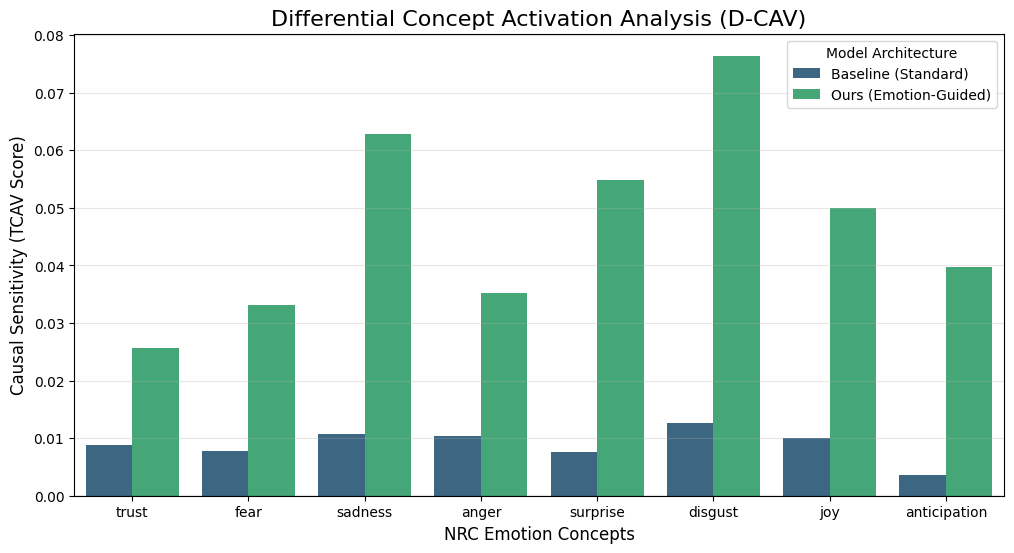

In [25]:
if len(results) > 0:
    df_res = pd.DataFrame(results)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_res, x="Emotion", y="Sensitivity", hue="Model", palette="viridis")
    
    plt.title("Differential Concept Activation Analysis (D-CAV)", fontsize=16)
    plt.ylabel("Causal Sensitivity (TCAV Score)", fontsize=12)
    plt.xlabel("NRC Emotion Concepts", fontsize=12)
    plt.axhline(0, color='black', linewidth=0.8)
    plt.legend(title="Model Architecture")
    plt.grid(axis='y', alpha=0.3)
    
    plt.show()
else:
    print("No results to plot. Please check model paths.")